In [3]:
import plotly
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
import matplotlib.animation as animation
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.lines import Line2D
from scipy.signal import fftconvolve
from sklearn.svm import LinearSVC
from itertools import *
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import scipy  as sp

#!git clone https://github.com/HNinou/MathTools_TD2
#!unzip MathTools_TD2/dic_cont8_GO.npy.zip -d MathTools_TD2/

In [6]:
!git clone https://github.com/HNinou/MathTools_TD2
!unzip MathTools_TD2/dic_cont8_GO.npy.zip -d MathTools_TD2/

Cloning into 'MathTools_TD2'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 16.96 MiB | 18.92 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Archive:  MathTools_TD2/dic_cont8_GO.npy.zip
  inflating: MathTools_TD2/dic_cont8_GO.npy  
  inflating: MathTools_TD2/__MACOSX/._dic_cont8_GO.npy  


# Performing PCA on neural data


In [4]:
def gaussian(x, sigma, mu=0):
    return np.exp(-((x-mu)**2) / (2*sigma**2))

def make_conv_kernel( sigma= 30):
    nb_time_frames = 6*sigma
    conv_kernel = gaussian(np.arange(-nb_time_frames//2,nb_time_frames//2,1), sigma=sigma)
    conv_kernel /= np.sum(conv_kernel)

    return conv_kernel

def smoothen_data(dic, sigma=30):
    # Get number of neurons
    nb_neurons = len(dic['mat'])

    # Create the convolution kernel
    conv_kernel = make_conv_kernel(sigma=sigma)

    # Pre-allocate the smooth_mat with the same structure as dic['mat']
    smooth_mat = [None] * nb_neurons

    # Loop over neurons, but vectorize across trials
    for neuron in range(nb_neurons):
        # Get all trials for this neuron as a 2D matrix (nb_trials, time_points)
        mat_neuron = dic['mat'][neuron]

        # Use fftconvolve for faster convolution across all trials
        smooth_neuron = fftconvolve(mat_neuron, conv_kernel[None, :], mode='same', axes=1)

        # Store the result back
        smooth_mat[neuron] = smooth_neuron

    # Replace the original matrix with the smoothed data
    dic['sm_mat'] = smooth_mat
    return dic


def raster_plot(neural_data):
  # Create the raster plot using Plotly
  fig = go.Figure(data=go.Heatmap(
      z=neural_data,
      colorscale='Greys',
      colorbar=dict(
          title="Neural Activity",
          titleside='right',
          ticks='outside',
          ticklen=5,
          tickcolor='black',
      )
  ))

  fig.update_layout(
      title="Neural Activity Raster Plot",
      xaxis=dict(
          title="Time (ms)",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      yaxis=dict(
          title="Trial Index",
          ticks='outside',
          showline=True,
          linewidth=2,
          linecolor='black',
          mirror=True
      ),
      plot_bgcolor='white',
      font=dict(size=14),
  )

  # Display the plot
  fig.show()
  return()

The cell below stores the data in the dictionnary dic_cont8. The raw data is stored in dic_cont8['mat'] which is a list of size 777, that is the total number of neurons. Each element of this list contains a matrix of size (#trials x #timesteps). For each recording, that is for each trial, the data is shifted so that the 'GO' signal always shows up at the 2000th time frame.

In [7]:
# Load the data from the .npy files

centering = 'GO'
dic_cont8 =np.load('MathTools_TD2/dic_cont8_GO.npy', allow_pickle = True).flat[0]
# Smooth the data using a Gaussian filter with a sigma of 100
dic_cont8 = smoothen_data(dic_cont8, sigma=100)

nb_neurons = len(dic_cont8['target'])

nb_trials_cont8 = np.zeros(nb_neurons)
for i in range(nb_neurons):
    nb_trials_cont8[i] = dic_cont8['target'][i].shape[0]

In [8]:
nb_neurons= len(dic_cont8['mat'])
nb_trials = []
for n in range(nb_neurons):
    nb_trials.append(dic_cont8['mat'][n].shape[0])
nb_trials = np.array(nb_trials)

Let's store the number of trials per neuron for each of the 8 targets

In [9]:
nb_neurons= len(dic_cont8['mat'])
nb_trials_per_c = np.zeros((8,nb_neurons))
for k,target in enumerate(range(1,9)):
  for n in range(nb_neurons):
    nb_trials_per_c[k, n] = dic_cont8['mat'][n][dic_cont8['target'][n]==target].shape[0]


# 1) Fill in the cell below

In [10]:
neuron_filter_ct = np.zeros(nb_neurons) == 0

for n in range(nb_neurons):
  for target in range(1,9):
    if (dic_cont8['target'][n] == target).sum() < 20 :
        neuron_filter_ct[n] = False

In [11]:
neuron_filter_ct.sum()

np.int64(245)

There are 245 neurons fulfilling this condition.

In [12]:
# put the 10 first trials in the training set and the 2 last in the testing set

X = []
for n in range(nb_neurons):
    if neuron_filter_ct[n]:
        res = []
        for target in range(1,9):
            filter_res = np.where(dic_cont8['target'][n] == target)[0][:20]
            res.append(dic_cont8['sm_mat'][n][filter_res][:,1700:1701].mean(axis = 0).flatten())

        res = np.array(res)

        X.append(res.flatten())


X = np.array(X)

X -= X.mean(axis = 1)[:,None]

In [13]:
C = X@X.T
eigval, eigvec = np.linalg.eigh(C)

In [14]:
colors = np.zeros(400*8)
for target in range(8):
    colors[target:(target+1)] = target/7

fig = go.Figure()

# Add a 3D scatter plot with PC1, PC2, and PC3 as axes
fig.add_trace(go.Scatter3d(
    x=(eigvec[:,-1]  @ X),
    y=(eigvec[:,-2]  @ X),
    z=(eigvec[:,-3]  @ X),
    mode='markers',
    marker=dict(size = 10,
                  colorscale = 'Rainbow',
                  color = colors,
                  colorbar = dict(title ='Target',
                                  titleside = 'top',
                                  tickvals = np.linspace(0,1,8),
                                  ticktext=['1','2','3','4','5','6','7','8'],
                                  orientation = 'h',
                                  len = 0.3,
                                  x=0.8,
                                  y=0.9)),
    hovertemplate='X: %{x:.2f}<br>Y: %{y:.2f}<br>Z: %{z:.2f}<br>Intensity: %{marker.color:.2f}'
))

# Update layout for scientific journal-quality
fig.update_layout(
    title={
        'text': "Projection of the data on the first three principal components",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis=dict(
            title="PC1",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        yaxis=dict(
            title="PC2",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
        zaxis=dict(
            title="PC3",
            showgrid=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinewidth=2,
            zerolinecolor='lightgrey',
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True
        ),
    ),
    font=dict(
        family="Times New Roman, serif",
        size=12,
        color="black"
    ),
    margin=dict(l=80, r=40, t=80, b=80),
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="top",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    width=800,
    height=800
)

# Display the plot
fig.show()


Variance explained by the 3 first PCs ?

In [16]:
eigval[-3:].sum()/eigval.sum()

np.float64(0.9115596642605299)

The 3 first PCs explain 91% of the variance.

# 2)

In [ ]:
#example of the equation of the variable (not used later)
import math
tgt = math.degrees(160)
y = [math.cos(tgt/8) * (2*math.pi),math.sin(tgt/8) * (2*math.pi)]

# 3)

The cells below formats our data to build the targets and predictors of the training and testing sets.

In [34]:
nb_trials_train = 16
nb_trials_test = 4
nb_valid_neurons = neuron_filter_ct.sum()
t_start = 1700
t_end = 1701

In [44]:
def get_XY_train_test():

    # put the 16 first trials in the training set and the 4 last in the testing set

    X_train = []
    X_test = []
    for n in range(nb_neurons):
        if neuron_filter_ct[n]:
            res_train = []
            res_test = []
            for target in range(1,9):
                #Get all indices for the current target
                target_indices = np.where(dic_cont8['target'][n] == target)[0]

                # Perform a train-test split to get 16 training and 4 testing trials
                train_indices, test_indices = train_test_split(target_indices, test_size=4, train_size=16)

                # Append the corresponding data slices for training and testing
                res_train.append(dic_cont8['sm_mat'][n][train_indices][:, t_start:t_end])
                res_test.append(dic_cont8['sm_mat'][n][test_indices][:, t_start:t_end])


            res_train = np.array(res_train)
            res_test = np.array(res_test)

            X_train.append(res_train)
            X_test.append(res_test)


    X_train = np.array(X_train)
    X_test = np.array(X_test)

    X_train -= X_train.reshape((nb_valid_neurons,-1)).mean(axis =1)[:,None,None,None]
    X_test -= X_test.reshape((nb_valid_neurons,-1)).mean(axis =1)[:,None,None,None]

    X_train = X_train.swapaxes(0,2)
    X_train = X_train.swapaxes(0,1)
    X_train = X_train.reshape((8*nb_trials_train, nb_valid_neurons*(t_start-t_end)))

    X_test = X_test.swapaxes(0,2)
    X_test = X_test.swapaxes(0,1)
    X_test = X_test.reshape((8*nb_trials_test, nb_valid_neurons*(t_start-t_end)))

    Y1 = np.cos( np.arange(8)[:,None] * np.ones(nb_trials_train) * 2*np.pi/8).reshape(8*nb_trials_train)
    Y2 = np.sin( np.arange(8)[:,None] * np.ones(nb_trials_train) * 2*np.pi/8).reshape(8*nb_trials_train)
    Y_train = np.column_stack((Y1,Y2))

    Y1_test = np.cos( np.arange(8)[:,None] * np.ones(nb_trials_test) * 2*np.pi/8).reshape(8*nb_trials_test)
    Y2_test = np.sin( np.arange(8)[:,None] * np.ones(nb_trials_test) * 2*np.pi/8).reshape(8*nb_trials_test)
    Y_test = np.column_stack((Y1_test,Y2_test))

    return X_train, X_test, Y_train, Y_test


In [45]:
X_train, X_test, Y_train, Y_test = get_XY_train_test()

print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(128, 245) (32, 245)
(128, 2) (32, 2)


# 4)

In [46]:
inv_mat = np.linalg.inv(X_train.T @ X_train)

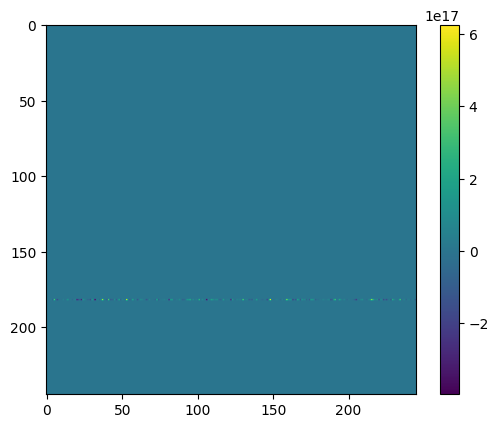

In [47]:
plt.imshow(inv_mat@(X_train.T@X_train))
plt.colorbar() #doesn't work because we should get the identity matrix

# 5)

# 6)

# 7)

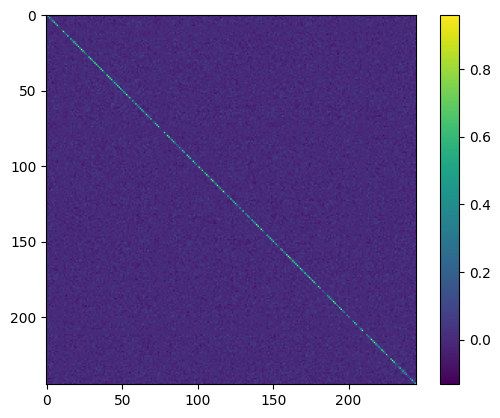

In [48]:
pinv_mat = np.linalg.pinv(X_train.T @ X_train)
plt.imshow(pinv_mat@(X_train.T@X_train))
plt.colorbar()

From now on, we will use the built in functions from scikit learn to implement our models.
The cell below builds a linear regression model with biases and fits the coefficients to the training data.

In [50]:
linreg_model = linear_model.LinearRegression(fit_intercept=True)
linreg_model.fit(X_train, Y_train)

LinearRegression()

The cell below evaluates the performance of the learned model on the test data.

In [51]:
linreg_model.score(X_test, Y_test)

0.8497695669778289

In [153]:
linreg_model.coef_.shape

(2, 245)

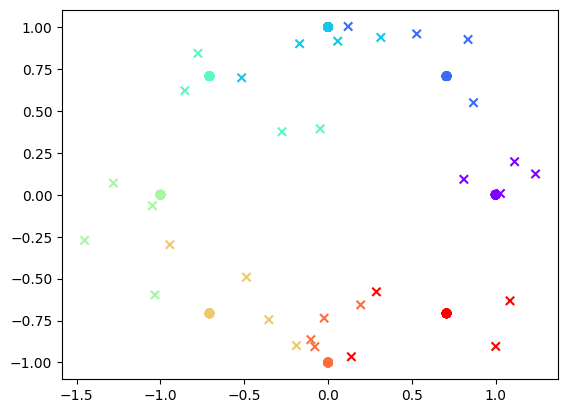

In [54]:
colors_train = (np.arange(8)[:,None]*np.ones(nb_trials_train)).reshape(8*nb_trials_train)
colors_test =  (np.arange(8)[:,None]*np.ones(nb_trials_test)).reshape(8*nb_trials_test)

plt.scatter(linreg_model.predict(X_train)[:,0], linreg_model.predict(X_train)[:,1], c = colors_train, cmap = 'rainbow')
plt.scatter(linreg_model.predict(X_test)[:,0], linreg_model.predict(X_test)[:,1], c = colors_test, cmap = 'rainbow', marker = 'x')

# 8)

# 9)

In [61]:
score_linreg = np.zeros(100)
for i in range(100):
    X_train, X_test, Y_train, Y_test = get_XY_train_test()
    linreg_model = linear_model.LinearRegression(fit_intercept=True)
    linreg_model.fit(X_train, Y_train)
    x = linreg_model.score(X_test, Y_test)

    score_linreg[i] = linreg_model.score(X_test, Y_test)

score_linreg.mean()


np.float64(0.8288249299626699)

In [183]:
score_linreg.mean()

np.float64(0.8261934270846194)

# 10)

This can take a while

In [ ]:
alpha_list = np.logspace(-6, -1, num=50, endpoint=True)
score_ridge = np.zeros((100,50))

In [91]:
cv_steps = 100
alpha_steps = 50

score_ridge = np.zeros((100,50))

counter = 0
for z in range(alpha_steps):
    alpha = alpha_list[z]
    for i in range(cv_steps):
        X_train, X_test, Y_train, Y_test = get_XY_train_test()
        ridge_model = linear_model.Ridge(alpha=alpha, fit_intercept=True)
        ridge_model.fit(X_train, Y_train)
        model_score = ridge_model.score(X_test, Y_test)
        score_ridge[i,z] = model_score

In [184]:
score_ridge.mean(axis=0)

array([0.83197938, 0.82096388, 0.83000265, 0.83327392, 0.82778954,
       0.83591557, 0.82763896, 0.82954172, 0.83426909, 0.82677051,
       0.82785124, 0.82647919, 0.83792633, 0.83493583, 0.83587728,
       0.83835779, 0.84138802, 0.84102745, 0.83701554, 0.85065432,
       0.85140537, 0.85525954, 0.85791417, 0.85501689, 0.86892074,
       0.87047494, 0.8752409 , 0.88111711, 0.88739388, 0.89035179,
       0.89690066, 0.90332297, 0.90218794, 0.90724251, 0.91188582,
       0.90953791, 0.9109548 , 0.91466996, 0.91557405, 0.91136911,
       0.91200687, 0.90588643, 0.90161263, 0.89717653, 0.88656414,
       0.87785447, 0.86587026, 0.84161762, 0.82105215, 0.79707787])

# 11)

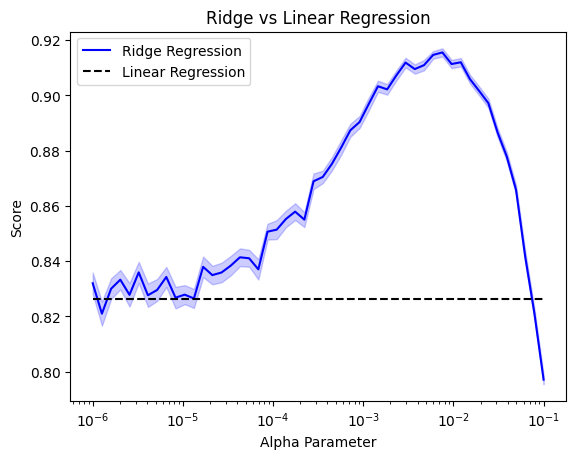

In [112]:
# Compute means and standard errors
ridge_mean = score_ridge.mean(axis=0)
ridge_sem = sp.stats.sem(score_ridge)
linreg_mean = score_linreg.mean()

# Plot Ridge Regression with shaded error area
plt.plot(alpha_list, ridge_mean, label='Ridge Regression', color='blue')
plt.fill_between(alpha_list, ridge_mean - ridge_sem, ridge_mean + ridge_sem, color='blue', alpha=0.2)

# Plot Linear Regression as a horizontal line
plt.hlines(y=linreg_mean, xmin=alpha_list[0], xmax=alpha_list[-1], color='black', linestyle='--', label='Linear Regression')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add labels, legend, and show the plot
plt.xlabel("Alpha Parameter")
plt.ylabel("Score")
plt.legend()
plt.title("Ridge vs Linear Regression")
plt.show()

11b

# 12)

In [121]:
opt_alpha = alpha_list[score_ridge.mean(axis=0).argmax()]
print('optimal alpha = ', opt_alpha)

optimal alpha =  0.007543120063354623


In [123]:
X_train, X_test, Y_train, Y_test = get_XY_train_test()
ridge_model = linear_model.Ridge(alpha=opt_alpha, fit_intercept=True)
ridge_model.fit(X_train, Y_train)

ridge_model.score(X_test, Y_test)

0.9472943687626889

In [139]:
ridge_model.coef_

array([[-1.04732233e-01, -5.74664369e-01, -8.15767771e-01,
        -8.23900197e-01,  1.34249416e-01,  1.82917819e+00,
         1.10550965e-01, -2.43417799e-01, -7.49915620e-01,
         2.19862208e-01,  6.28205580e-02, -9.56587732e-01,
        -5.41792804e-02,  8.51625657e-01,  2.84214058e+00,
        -5.13433033e-02, -1.78881104e-01, -1.78699965e+00,
         1.75371366e+00,  1.38205274e+00, -7.58339141e+00,
         1.55955594e+00, -2.04147022e+00, -4.74880086e-01,
        -2.89981209e+00,  1.44653246e+00,  2.71917592e-01,
        -2.33404037e-01,  1.26670665e+00, -1.38705690e+00,
        -3.95581809e-01, -7.86020222e-01, -1.44281806e+00,
         1.36016751e+00,  1.13144458e+00, -1.12179819e+00,
        -3.75233214e-01,  7.66912314e+00, -3.33612435e-01,
        -4.85443657e-01,  9.24796494e-01,  9.74392222e-01,
         1.33419563e+00, -1.97668537e+00, -2.77582752e-02,
         4.61459075e-03,  1.23851197e+00,  1.91399641e+00,
        -1.38934013e+00, -2.10591735e+00,  7.64950541e-0

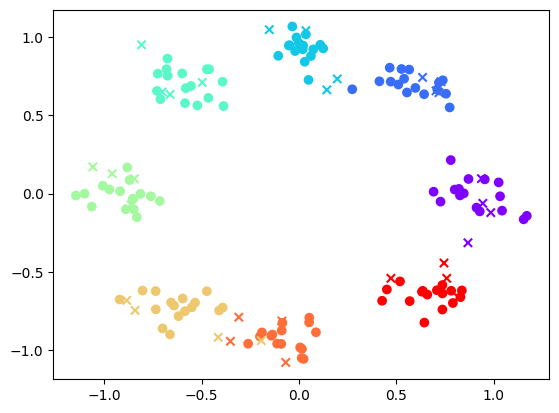

In [124]:
colors_train = (np.arange(8)[:,None]*np.ones(nb_trials_train)).reshape(8*nb_trials_train)
colors_test =  (np.arange(8)[:,None]*np.ones(nb_trials_test)).reshape(8*nb_trials_test)

plt.scatter(ridge_model.predict(X_train)[:,0], ridge_model.predict(X_train)[:,1] , c = colors_train, cmap = 'rainbow')
plt.scatter(ridge_model.predict(X_test)[:,0], ridge_model.predict(X_test)[:,1] , c = colors_test, cmap = 'rainbow', marker = 'x')

# 13)

In [125]:
X_train, X_test, Y_train, Y_test = get_XY_train_test()
lasso_model = linear_model.Lasso(alpha=0.0001, fit_intercept=True)
lasso_model.fit(X_train, Y_train)

lasso_model.score(X_test, Y_test)

0.910781805698806

In [186]:
lasso_model.coef_

array([[ 0.        , -0.        , -0.        , -0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ,  3.61898909,
         0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        -8.05532877,  0.        , -0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ,  0.        ,
        -0.        ,  0.        , 13.67018504, -0.        , -0.        ,
        -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ,
         0.        ,  0.        , -0.        ,  0.        , -0.        ,
        -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        -0.        ,  0.        , -0.        ,  0. 

In [182]:
#This block creates a Dataframe with the non-zero coefficients of the Lasso regression.
d = (pd.DataFrame(lasso_model.coef_)).T
d['sum'] = d.sum(axis=1)
d[d['sum']>0]

,0,1,sum
14,3.618989,0.000000,3.618989
34,0.000000,4.267616,4.267616
37,13.670185,0.000000,13.670185
53,0.000000,4.009058,4.009058
101,0.000000,2.346274,2.346274
117,-0.543834,7.955347,7.411513
139,0.000000,1.924383,1.924383
140,-0.800768,2.933482,2.132714
159,0.000000,0.243954,0.243954
216,20.803162,0.000000,20.803162


# 14)

This can take a while

In [131]:
cv_steps = 100
alpha_steps_lasso = 50

alpha_list_lasso = np.logspace(-5, -3, num=alpha_steps_lasso, endpoint=True)


score_lasso = np.zeros((100,50))

counter = 0
for z in range(alpha_steps_lasso):
    alpha = alpha_list_lasso[z]
    for i in range(cv_steps):
        X_train, X_test, Y_train, Y_test = get_XY_train_test()
        lasso_model = linear_model.Lasso(alpha=alpha, fit_intercept=True)
        lasso_model.fit(X_train, Y_train)
        model_score = lasso_model.score(X_test, Y_test)
        score_lasso[i,z] = model_score
        counter += 1
        print(counter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [132]:
opt_lasso_alpha = alpha_list_lasso[score_lasso.mean(axis=0).argmax()]


print('optimal alpha = ', opt_lasso_alpha)

optimal alpha =  8.68511373751352e-05


# 15)

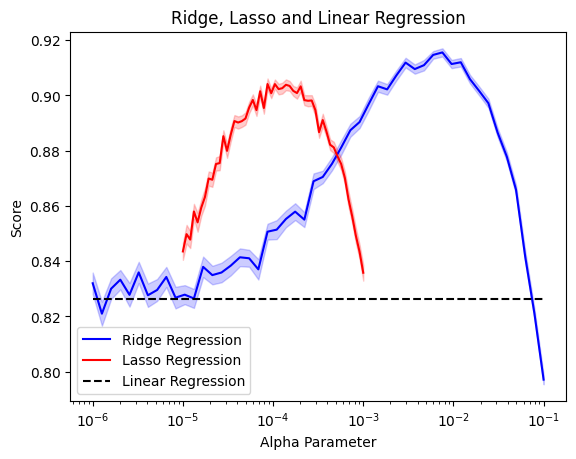

In [135]:
# Compute means and standard errors
ridge_mean = score_ridge.mean(axis=0)
ridge_sem = sp.stats.sem(score_ridge)
lasso_mean = score_lasso.mean(axis=0)
lasso_sem = sp.stats.sem(score_lasso)
linreg_mean = score_linreg.mean()

# Plot Ridge Regression with shaded error area
plt.plot(alpha_list, ridge_mean, label='Ridge Regression', color='blue')
plt.fill_between(alpha_list, ridge_mean - ridge_sem, ridge_mean + ridge_sem, color='blue', alpha=0.2)

# Plot Lasso Regression with shaded error area
plt.plot(alpha_list_lasso, lasso_mean, label='Lasso Regression', color='red')
plt.fill_between(alpha_list_lasso, lasso_mean - lasso_sem, lasso_mean + lasso_sem, color='red', alpha=0.2)


# Plot Linear Regression as a horizontal line
plt.hlines(y=linreg_mean, xmin=alpha_list[0], xmax=alpha_list[-1], color='black', linestyle='--', label='Linear Regression')

# Set x-axis to logarithmic scale
plt.xscale('log')

# Add labels, legend, and show the plot
plt.xlabel("Alpha Parameter")
plt.ylabel("Score")
plt.legend()
plt.title("Ridge, Lasso and Linear Regression")
plt.show()